### The Bostson Housing Proce dataset
We will attempt to precit the median proce of homes in given Boston suburb.

Dataset has only 506 datapoints split between 404 for training and 102 for test

Each feature of the input data has a different scale.

#### Load the data

In [1]:
from keras.datasets import boston_housing
(train_data, train_target), (test_data, test_target) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [2]:
train_data.shape, train_target.shape

((404, 13), (404,))

In [3]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [4]:
train_target[0]

15.2

#### Preparing the data

In [6]:
#Nornalising the data as the scales are different for each feature
#Will use Z-score or Standardisation method
import numpy as np
mean = train_data.mean(axis=0)
mean

array([3.74511057e+00, 1.14801980e+01, 1.11044307e+01, 6.18811881e-02,
       5.57355941e-01, 6.26708168e+00, 6.90106436e+01, 3.74027079e+00,
       9.44059406e+00, 4.05898515e+02, 1.84759901e+01, 3.54783168e+02,
       1.27408168e+01])

In [9]:
mean1 = np.mean(train_data, axis=0)
mean1

array([3.74511057e+00, 1.14801980e+01, 1.11044307e+01, 6.18811881e-02,
       5.57355941e-01, 6.26708168e+00, 6.90106436e+01, 3.74027079e+00,
       9.44059406e+00, 4.05898515e+02, 1.84759901e+01, 3.54783168e+02,
       1.27408168e+01])

In [10]:
train_data -= mean

In [11]:
std = train_data.std(axis=0)
train_data /= std

In [12]:
#Applying to test data (Remember to use men and std of train data, dont tuch he test for calculation)
test_data -= mean
test_data /= std

#### Building the netwrok

In [13]:
from keras import models, layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, input_shape=(13,), activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### K-Fold Validation
We will perform the K-fod validation as we less data and splitting it further for validation will reduced the data for both val and train.

In [16]:
k=4
num_val_samples = len(train_data)/4  #101.0
num_epochs = 100
all_scores = []

In [27]:
#Integer added otherwise the slice indices must be integer or None error throws
for i in range(k):
    print(f'processing fold: {i}')
    start = int(i * num_val_samples)
    end = int((i + 1) * num_val_samples)
    val_data = train_data[start : end]
    val_target = train_target[start : end]
    
    partial_train_data = np.concatenate([train_data[:int(i * num_val_samples)],
                                        train_data[int((i+1) * num_val_samples):]],
                                       axis=0)
    
    partial_train_target = np.concatenate([train_target[:int(i * num_val_samples)],
                                        train_target[int((i+1) * num_val_samples):]],
                                       axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_target, epochs=num_epochs, batch_size=1, verbose=1)
    val_mse, val_mae = model.evaluate(val_data, val_target, verbose=0)
    all_scores.append(val_mae)

processing fold: 0
Epoch 1/100
303/303 [==============================] - 1s 3ms/step - loss: 254.9310 - mae: 12.3191
Epoch 2/100
303/303 [==============================] - 0s 1ms/step - loss: 27.4236 - mae: 3.6515
Epoch 3/100
303/303 [==============================] - 0s 1ms/step - loss: 20.3523 - mae: 3.1153
Epoch 4/100
303/303 [==============================] - 0s 1ms/step - loss: 16.5969 - mae: 2.7253
Epoch 5/100
303/303 [==============================] - 0s 1ms/step - loss: 15.6491 - mae: 2.6289
Epoch 6/100
303/303 [==============================] - 0s 1ms/step - loss: 14.7204 - mae: 2.5205
Epoch 7/100
303/303 [==============================] - 0s 1ms/step - loss: 14.1365 - mae: 2.4111
Epoch 8/100
303/303 [==============================] - 0s 1ms/step - loss: 13.0563 - mae: 2.4564
Epoch 9/100
303/303 [==============================] - 0s 1ms/step - loss: 12.7054 - mae: 2.3957
Epoch 10/100
303/303 [==============================] - 0s 1ms/step - loss: 12.5542 - mae: 2.3446
Epoch 11

In [28]:
all_scores

[2.100100517272949, 2.4817845821380615, 2.641906976699829, 2.443516731262207]

In [30]:
np.mean(all_scores)

2.4168272018432617

We are off by $2400 which is significant considering entire price range is between 10K to 5K.
Lets try to train the model bit longer

In [35]:
# You may face error if you use element val_mean_absolute_error so use val_mae
#Link for reference: https://stackoverflow.com/questions/60053547/how-to-resolve-keyerror-val-mean-absolute-error-keras-2-3-1-and-tensorflow-2

num_epochs = 500
all_mae_history=[]
for i in range(k):
    print(f'processing fold: {i}')
    start = int(i * num_val_samples)
    end = int((i + 1) * num_val_samples)
    val_data = train_data[start : end]
    val_target = train_target[start : end]
    
    partial_train_data = np.concatenate([train_data[:int(i * num_val_samples)],
                                        train_data[int((i+1) * num_val_samples):]],
                                       axis=0)
    
    partial_train_target = np.concatenate([train_target[:int(i * num_val_samples)],
                                        train_target[int((i+1) * num_val_samples):]],
                                       axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_target, validation_data=(val_data, val_target), 
                        epochs=num_epochs, batch_size=1, verbose=1)
    mae_history = history.history['val_mae']
    all_mae_history.append(mae_history)

processing fold: 0
Train on 303 samples, validate on 101 samples
Epoch 1/500
303/303 [==============================] - 1s 3ms/step - loss: 197.4736 - mae: 10.6076 - val_loss: 39.2441 - val_mae: 4.3012
Epoch 2/500
303/303 [==============================] - 1s 2ms/step - loss: 29.8916 - mae: 3.7246 - val_loss: 23.6144 - val_mae: 3.0600
Epoch 3/500
303/303 [==============================] - 1s 2ms/step - loss: 22.3497 - mae: 3.1344 - val_loss: 20.0807 - val_mae: 3.0697
Epoch 4/500
303/303 [==============================] - 1s 2ms/step - loss: 18.9550 - mae: 2.8983 - val_loss: 16.1180 - val_mae: 2.5958
Epoch 5/500
303/303 [==============================] - 1s 2ms/step - loss: 17.3941 - mae: 2.6911 - val_loss: 14.4701 - val_mae: 2.5216
Epoch 6/500
303/303 [==============================] - 1s 2ms/step - loss: 15.0005 - mae: 2.5832 - val_loss: 16.2106 - val_mae: 2.4375
Epoch 7/500
303/303 [==============================] - 1s 2ms/step - loss: 15.2625 - mae: 2.5431 - val_loss: 13.2052 - val_

In [36]:
all_mae_history

[[4.301179885864258,
  3.059983253479004,
  3.069667100906372,
  2.595834493637085,
  2.5216405391693115,
  2.437466859817505,
  2.373643398284912,
  2.1448168754577637,
  2.333035707473755,
  2.193291425704956,
  2.304309129714966,
  2.236607551574707,
  2.138570547103882,
  2.2384755611419678,
  1.9895036220550537,
  2.1508631706237793,
  2.1024320125579834,
  2.0827460289001465,
  2.0790860652923584,
  2.1717417240142822,
  2.3282418251037598,
  2.3374314308166504,
  2.0185906887054443,
  2.3021492958068848,
  1.9993174076080322,
  2.0321261882781982,
  2.172335624694824,
  2.0452053546905518,
  1.9198672771453857,
  2.351496458053589,
  2.129251480102539,
  2.032116174697876,
  1.9873384237289429,
  1.8315705060958862,
  2.0394556522369385,
  2.033109426498413,
  2.0422425270080566,
  2.023674726486206,
  2.6892099380493164,
  2.0510215759277344,
  2.184401750564575,
  2.183293581008911,
  1.929653525352478,
  1.9863816499710083,
  1.95508873462677,
  1.8350971937179565,
  1.924622

In [37]:
len(all_mae_history)

4

In [38]:
len(all_mae_history[0])

500

#### Compute the average of the per-epoch MAE score

In [42]:
average_mae_history = [np.mean([x[i] for x in all_mae_history]) for i in range(num_epochs)]

In [44]:
len(average_mae_history)

500

In [45]:
average_mae_history[:10]

[4.467552721500397,
 3.37244313955307,
 3.0631797909736633,
 2.7685095071792603,
 2.797855257987976,
 2.6879181265830994,
 2.6945276856422424,
 2.5065948963165283,
 2.622217118740082,
 2.5140486359596252]

#### Plotting the avergae mae w.r.t epochs

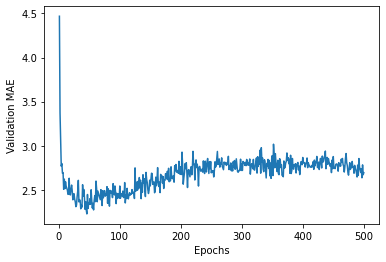

In [46]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [47]:
# Making the plot more smooth hence we will remove first 10 items 
# Basiaclly we will replace point with an exonentially moving avergae of the previous points
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point * (1- factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [48]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

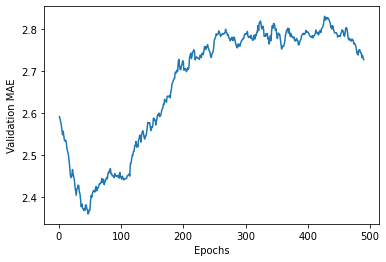

In [49]:
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Observation: After epoch 50 - 60 MAE performance is not improving rather its started overfitting. So we have to tune the model by reducing the epoch and some other parameters.

#### Training the final model

In [55]:
model = build_model()
model.fit(train_data, train_target, epochs=50, batch_size=32, verbose=1)
test_mse_score, test_mae_score = model.evaluate(test_data, test_target)

Epoch 1/50
404/404 [==============================] - 0s 1ms/step - loss: 553.1738 - mae: 21.6849
Epoch 2/50
404/404 [==============================] - 0s 57us/step - loss: 460.7960 - mae: 19.6327
Epoch 3/50
404/404 [==============================] - 0s 55us/step - loss: 362.3932 - mae: 17.1491
Epoch 4/50
404/404 [==============================] - 0s 53us/step - loss: 260.7672 - mae: 14.2051
Epoch 5/50
404/404 [==============================] - 0s 56us/step - loss: 172.3558 - mae: 10.9418
Epoch 6/50
404/404 [==============================] - 0s 54us/step - loss: 108.4711 - mae: 8.3703
Epoch 7/50
404/404 [==============================] - 0s 55us/step - loss: 71.0360 - mae: 6.5676
Epoch 8/50
404/404 [==============================] - 0s 54us/step - loss: 50.6576 - mae: 5.5343
Epoch 9/50
404/404 [==============================] - 0s 57us/step - loss: 38.0877 - mae: 4.6833
Epoch 10/50
404/404 [==============================] - 0s 57us/step - loss: 29.6438 - mae: 4.0494
Epoch 11/50
404/404

In [56]:
test_mse_score, test_mae_score

(18.48342611275467, 2.8430378437042236)

Still we are off by $2840 